# Track cells over time

In [20]:
import matplotlib.pyplot as plt

import cv2
import natsort
import numpy as np
import os
import glob
import pandas as pd
import sys
import trackpy as tp
import scipy.misc
import skimage.filters
import sklearn.metrics
import warnings; warnings.simplefilter('ignore')

import matplotlib as mpl
mpl.rc('figure',  figsize=(10, 6))
plt.ion()

1. Dataset - Rat mesenchymal stem cells on a flat polyacrylamide substrate from the http://celltrackingchallenge.net/2d-datasets/ is used
2. To understand how data is annotated and ground truths are saved - https://drive.google.com/file/d/1MGiwJo6h6PmUNzjL83JM77mYGFm8khH0/view?usp=sharing

Thanks and References to the dataset - 
1. Martin Maška, Vladimír Ulman, David Svoboda, Pavel Matula, Petr Matula, Cristina Ederra, Ainhoa Urbiola, Tomás España, Subramanian Venkatesan, Deepak M.W. Balak, Pavel Karas, Tereza Bolcková, Markéta Štreitová, Craig Carthel, Stefano Coraluppi, Nathalie Harder, Karl Rohr, Klas E. G. Magnusson, Joakim Jaldén, Helen M. Blau, Oleh Dzyubachyk, Pavel Křížek, Guy M. Hagen, David Pastor-Escuredo, Daniel Jimenez-Carretero, Maria J. Ledesma-Carbayo, Arrate Muñoz-Barrutia, Erik Meijering, Michal Kozubek, Carlos Ortiz-de-Solorzano; A benchmark for comparison of cell tracking algorithms, Bioinformatics, Volume 30, Issue 11, 1 June 2014, Pages 1609–1617, https://doi.org/10.1093/bioinformatics/btu080
2. Ulman, Vladimír & Maška, Martin & E G Magnusson, Klas & Ronneberger, Olaf & Haubold, Carsten & Harder, Nathalie & Matula, Pavel & Matula, Petr & Svoboda, David & Radojevic, Miroslav & Smal, Ihor & Rohr, Karl & Jaldén, Joakim & Blau, Helen & Dzyubachyk, Oleh & Lelieveldt, Boudewijn & Xiao, Pengdong & Li, Yuexiang & Cho, Siu-Yeung & Ortiz-de-Solorzano, Carlos. (2017). An Objective Comparison of Cell Tracking Algorithms. Nature Methods. 14. 10.1038/nmeth.4473. 


In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data")
GRAYSCALE_DIR = os.path.join(DATA_DIR,"grayscale") + os.sep
GROUNDTRUTH_SEGMENTED_DIR = os.path.join(DATA_DIR, "groundtruth_segmentation") + os.sep
GROUNDTRUTH_TRACKING_DIR = os.path.join(DATA_DIR, "groundtruth_tracking") + os.sep
LI_THRESHOLDED_DIR = os.path.join(DATA_DIR, "li_thresholded") + os.sep
YEN_THRESHOLDED_DIR = os.path.join(DATA_DIR, "yen_thresholded") + os.sep
OTSU_THRESHOLDED_DIR = os.path.join(DATA_DIR, "otsu_thresholded") + os.sep
CONFUSION_MATRIX_MASK_DIR = os.path.join(DATA_DIR, "confusion_matrix") + os.sep

GRAYSCALE_IMAGES = natsort.natsorted(glob.glob(GRAYSCALE_DIR + "*.tif"))
GROUNDTRUTH_SEGMENTED_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_SEGMENTED_DIR + "*.tif"))
GROUNDTRUTH_TRACKING_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_TRACKING_DIR + "*.tif"))

print("number of grayscale images are {}".format(len(GRAYSCALE_IMAGES)))
print("number of images manually segmented are {}".format(len(GROUNDTRUTH_SEGMENTED_IMAGES)))
print("number of images manually tracked are {}".format(len(GROUNDTRUTH_TRACKING_IMAGES)))
      
# Not all images are manually segmented, collect the subset of grayscale images that are manually segmented
data_files = []
for data in GRAYSCALE_IMAGES:
    for groundtruth in GROUNDTRUTH_SEGMENTED_IMAGES:
        if os.path.basename(groundtruth) == os.path.basename(data):
            data_files.append(data)

print("obtained {} number of grayscale images that are manually segmented".format(len(data_files)))

# To generate a video/gif from images in a folder/directory using ffmpeg run
# ffmpeg -framerate 5 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

number of grayscale images are 48
number of images manually segmented are 18
number of images manually tracked are 48
obtained 18 number of grayscale images that are manually segmented


Grayscale image info
/home/pranathi/personal_code/cell-tracking/cell-tracking/data/grayscale/t005.tif
(832, 992)
uint16
Ground truth for segmentation image info
/home/pranathi/personal_code/cell-tracking/cell-tracking/data/groundtruth_segmentation/t005.tif
(832, 992)
uint16
[0 1 2 3 4 5 6 7 8]
Ground truth for tracking image info
/home/pranathi/personal_code/cell-tracking/cell-tracking/data/groundtruth_tracking/t005.tif
(832, 992)
uint16
[ 0  1  3  4  6  7  9 11 12]


(-0.5, 991.5, 831.5, -0.5)

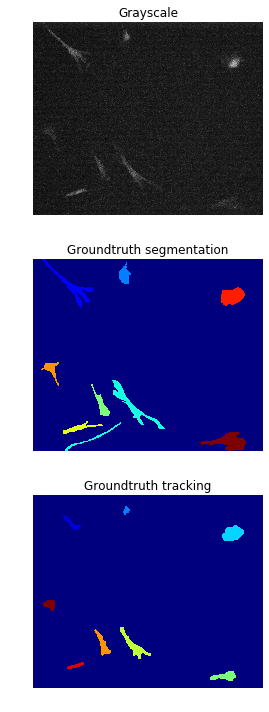

In [22]:
print("Grayscale image info")
grayscale_im_name = os.path.join(
        GRAYSCALE_DIR, os.path.basename(GROUNDTRUTH_SEGMENTED_IMAGES[0]))
grayscale_im = scipy.misc.imread(grayscale_im_name)
print(grayscale_im_name)
print(grayscale_im.shape)
print(grayscale_im.dtype)

print("Ground truth for segmentation image info")
segment_gt_name =  os.path.join(
    GROUNDTRUTH_SEGMENTED_DIR,os.path.basename(GROUNDTRUTH_SEGMENTED_IMAGES[0]))
segment_gt = scipy.misc.imread(segment_gt_name)
print(segment_gt_name)
print(segment_gt.shape)
print(segment_gt.dtype)
print(np.unique(segment_gt))

print("Ground truth for tracking image info")
tracking_gt_name = os.path.join(
        GROUNDTRUTH_TRACKING_DIR, os.path.basename(GROUNDTRUTH_SEGMENTED_IMAGES[0]))
tracking_gt = scipy.misc.imread(tracking_gt_name)
print(tracking_gt_name)
print(tracking_gt.shape)
print(tracking_gt.dtype)
print(np.unique(tracking_gt))

plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.imshow(grayscale_im, cmap='gray')
plt.title("Grayscale")
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(segment_gt, cmap='jet')
plt.title("Groundtruth segmentation")
plt.axis("off")
plt.subplot(3, 1, 3)
plt.imshow(tracking_gt, cmap='jet')
plt.title("Groundtruth tracking")
plt.tight_layout()
plt.axis("off")

In [29]:
def images_to_npy(im_names):
    """
    Loads all images and converts them to a numpy stack

    Inputs:
    data_dir = list of images

    Outputs:
    returns image stack as (z stack, tile size_x, tile size_y)
    """
    image = scipy.misc.imread(im_names[0])
    shape = image.shape
    dtype = image.dtype
    im_stack = np.zeros((len(im_names), shape[0], shape[1]), dtype=dtype)
    
    for i in range(len(im_names)):
        im = scipy.misc.imread(im_names[i])
        im_stack[i, :, :] = im

    return im_stack

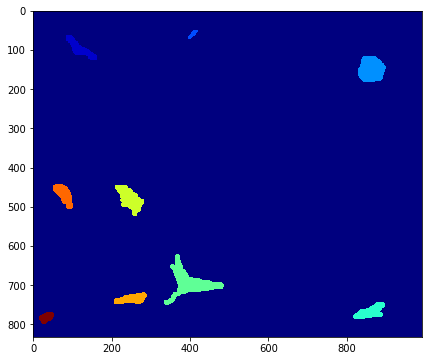

In [30]:
# Make a stack of all the frames that are already segmented/tracked
tracking_groundtruth_stack = images_to_npy(GROUNDTRUTH_TRACKING_IMAGES)
# Plot the first image
plt.imshow(tracking_groundtruth_stack[0], cmap='jet')

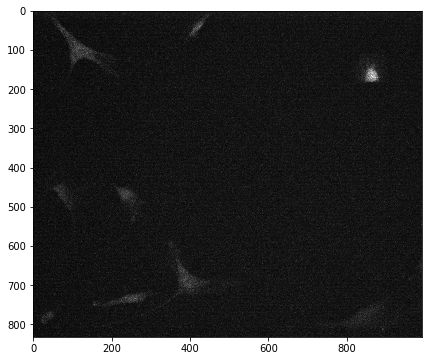

In [31]:
# Make a stack of all the raw frames in grayscale
grayscale_stack = images_to_npy(GRAYSCALE_IMAGES)
# Plot the first image
plt.imshow(grayscale_stack[0], cmap='gray')

1. From the picture above we can see that cells are not ellipses or circles i.e diameters would vary in different directions. we can find diameter of the cells by fitting ellipses and finding major and minor axis using opencv contours for one segmented image and repeat if for n segmented images to find average size in x, y that would work to locate and track the cells. 

2. As a start point, we can estimate it by looking at it, we can see each cell is atleast 10 pixel wide in both x and y, so we can start off with 11. 

# Usage of trackpy(tp)
1. Purpose of the Function tp.locate - Locates Gaussian-like bright blobs of some approximate size(diameter) in an image with a given separation between two blobs/features/cells.
2. Notes on parameter "diameter" - Diameter/Size may be a single number or a tuple giving the feature's extent in each dimension, useful when the dimensions do not have equal resolution (e.g. confocal microscopy). The tuple order is the same as the image shape, conventionally (z, y, x) or (y, x). The number(s) must be odd integers

Estimate feature size

Text(0.5, 1.0, 'Diameter(x) vs cell count(y)')

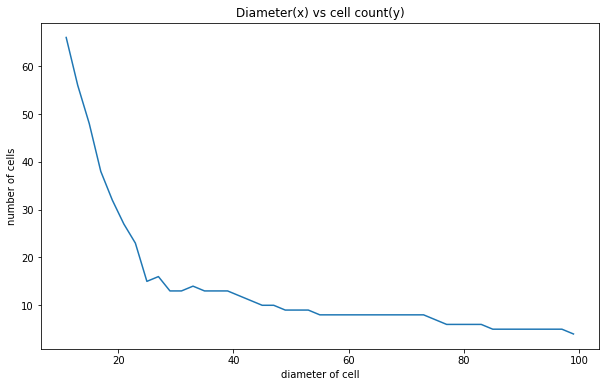

In [34]:
# Look at first frame to find a rough estimate of feature size

detected_cell_count = []
cell_sizes = []

for diameter in range(10, 100):
    if diameter % 2 != 0:
        cell_df = tp.locate(tracking_groundtruth_stack[0, :, :], diameter=diameter, separation=diameter+1)
        number_of_detected_cells = cell_df.shape[0]
        detected_cell_count.append(number_of_detected_cells)
        cell_sizes.append(diameter)

plt.plot(cell_sizes, detected_cell_count)
plt.xlabel("diameter of cell")
plt.ylabel("number of cells")
plt.title("Diameter(x) vs cell count(y)")

There are 9 cells if we count in the ground truth image, and it seems like diameter of cells greater than 20 are close to having cells less less than or equal to 10. so, lets locate and plot features obtained onto the original image for the diameter range within 20 to 80

# Locate features

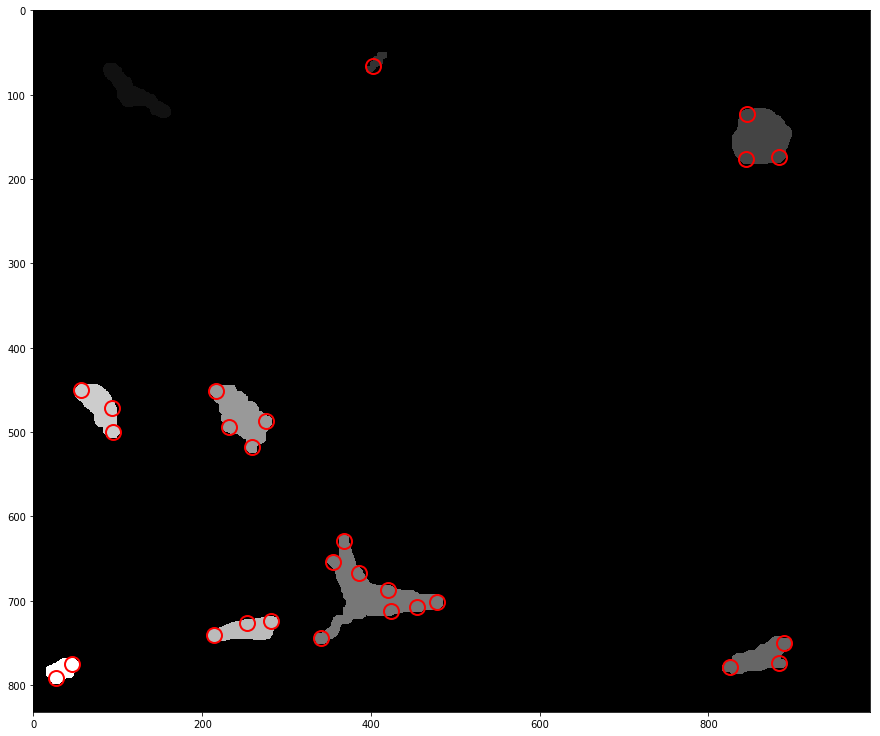

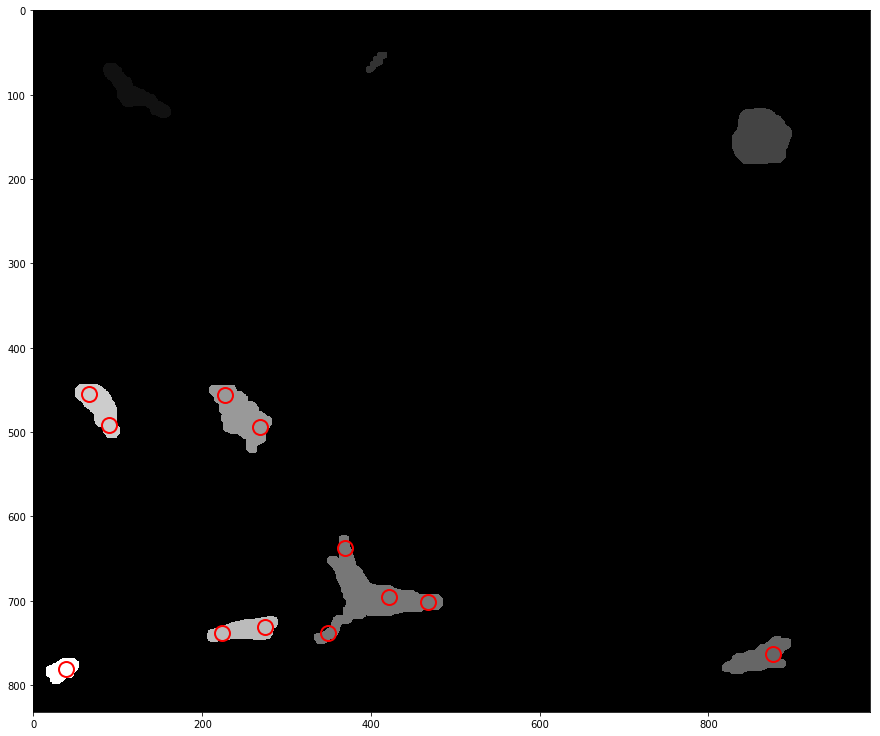

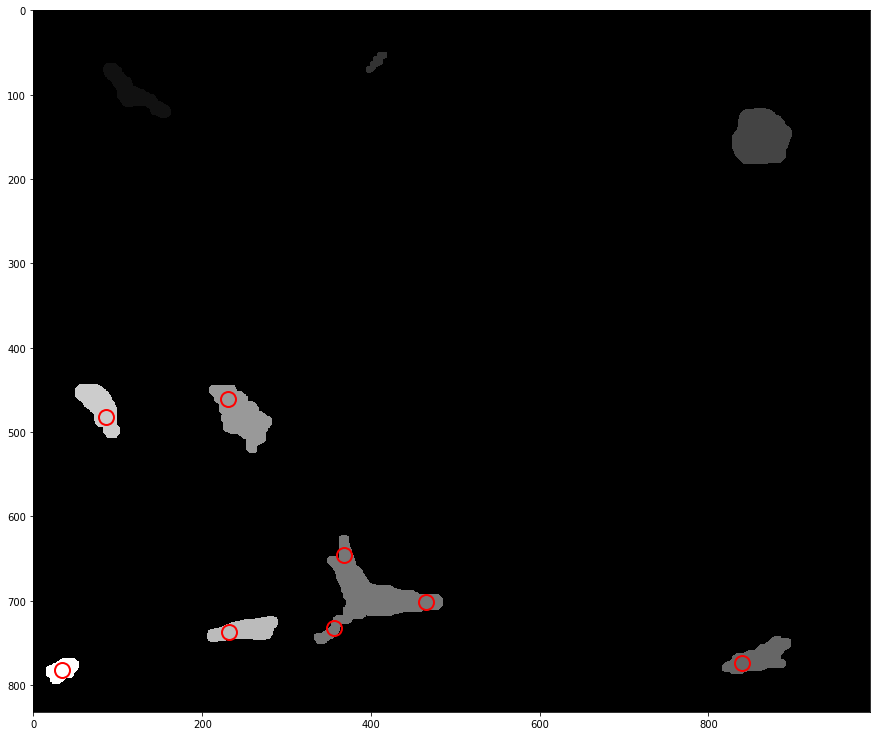

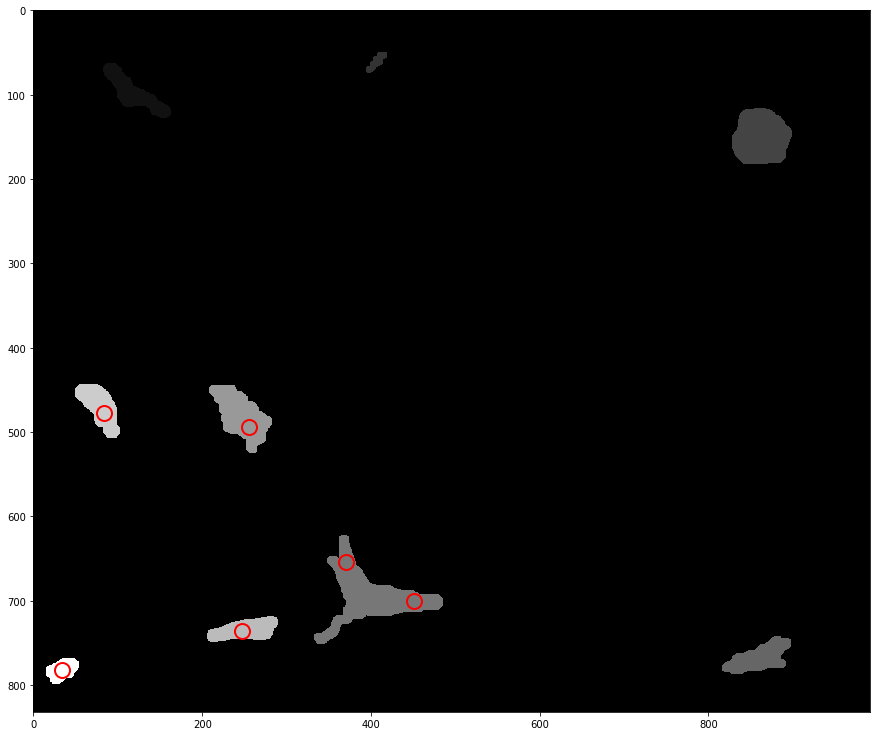

In [39]:
for diameter in range(21, 100, 20):
    if diameter % 2 == 0: diameter = diameter + 1
    cell_df = tp.locate(
        tracking_groundtruth_stack[0, :, :], diameter=diameter, separation=diameter+1)
    plt.figure()
    plt.rcParams['figure.figsize'] = [15, 15]
    tp.annotate(cell_df, tracking_groundtruth_stack[0, :, :])

In [40]:
print(cell_df.head())

              y           x          mass       size       ecc     signal  \
7    477.229237   83.398281  13463.350851  23.101708  0.439271  10.999832   
22   493.682920  255.630557  11729.658442  25.351868  0.323176   7.999878   
45   654.396573  369.849395   7325.620752  22.527521  0.533512   6.999893   
167  700.616326  451.183697   8706.132692  21.527452  0.561303   6.999893   
640  735.183057  247.647422  15062.113252  23.189860  0.612623   9.999847   

     raw_mass   ep  
7     17652.0  0.0  
22    17100.0  0.0  
45     9632.0  0.0  
167   10668.0  0.0  
640   17809.0  0.0  


# Refine parameters to elminate spurious features

10.6208805056 50.9462601788 255


[Text(0, 0.5, 'count'), Text(0.5, 0, 'mass')]

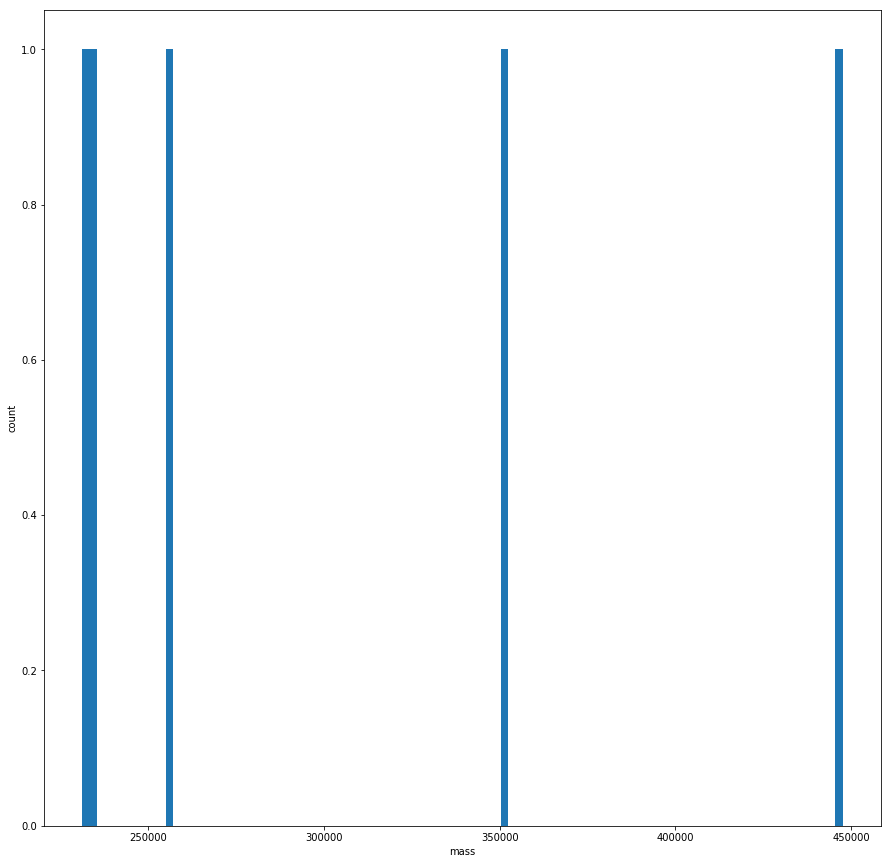

In [135]:
fig, ax = plt.subplots()
ax.hist(cell_df['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count')
ax.title("mass vs count")

In [137]:
frames_df = tp.batch(tracking_groundtruth_stack, diameter=diameter, minmass=minmass, maxsize=maxsize, percentile=percentile)

Frame 17: 16 features


In [138]:
track_df = tp.link_df(frames_df, 20, memory=3)
print('Before:', track_df['particle'].nunique())
track_df = tp.filter_stubs(track_df, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('After:', track_df['particle'].nunique())
print(track_df.head())

Frame 17: 16 trajectories present.
Before: 322
After: 0
Empty DataFrame
Columns: [y, x, mass, size, ecc, signal, raw_mass, ep, frame, particle]
Index: []


ValueError: DataFrame of trajectories is empty.

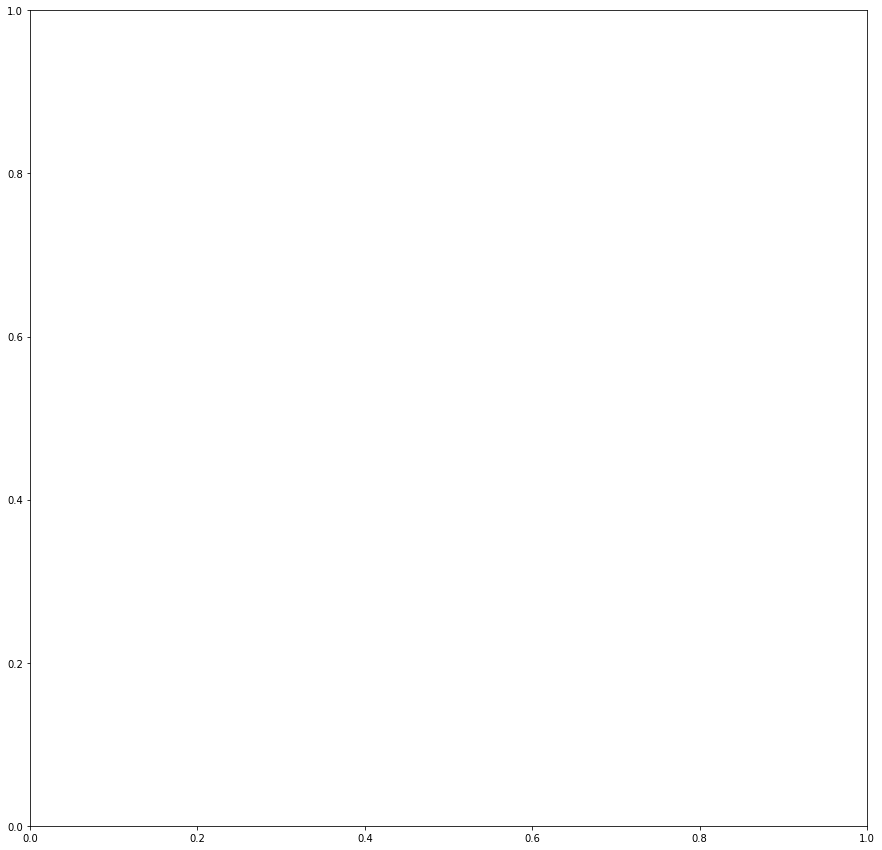

In [139]:
plt.figure()
tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0]).set_xlim(300,600)

In [140]:
drift_df = tp.compute_drift(track_df)
plt.figure()
drift_df.plot()

ValueError: 'frame' is both an index level and a column label, which is ambiguous.

In [141]:
track_df = tp.subtract_drift(track_df, drift_df)
plt.figure()
tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0]).set_xlim(300,600)

NameError: name 'drift_df' is not defined